## MVP

Here, I will outline steps for my MVP, including Data Loading, Data Cleaning, and Preperation of Data for Training

In [1]:
import requests
import pandas as pd
import time


Get API Key from Google Collab Account

In [11]:
from Keys import API_KEY

API_KEY = API_KEY

In [12]:
from googleapiclient.discovery import build
youtube = build('youtube','v3', developerKey = API_KEY)

In [13]:
world_cities = pd.read_csv('worldcities.csv')
world_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


In [14]:
world_cities_first = world_cities[0:20]
world_cities_second = world_cities[20:][world_cities['country'] != 'China']
world_cities = pd.concat((world_cities_first,world_cities_second), axis = 0).reset_index(drop = True)


C:\Users\kenhu\AppData\Local\Temp/ipykernel_6756/3597982440.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  world_cities_second = world_cities[20:][world_cities['country'] != 'China']


Next, we need to pull data from API. We will write a function to do this. There are two steps to this:

1. Search: We are searching the most popular videos pertaining to the key word: "[City name] + travel". From this, we can obtain the Video ID for the top 50 items.
2. Video: From Video ID, we can find the Video title + Views


In [15]:
json_list = []
def search_city(x):

    city = x[1]
    print(city)
    search_list = youtube.search().list(
        part="snippet",
        maxResults = 50,
        q="travel " + city,
        order = 'viewCount',
        type="video"
        ).execute()
    json_list.append(search_list)
    videos = pd.DataFrame(columns = ['video_id','video_title','view_count'])
    vid_title_list = []
    vid_id_list = []
    vid_count_list = []
    for i in range(0, len(search_list['items'])):
        vid_title_list.append(search_list['items'][i]['snippet']['title'])
        
        vid_id = search_list['items'][i]['id']['videoId']
        vid_id_list.append(vid_id)
        
        videostats = youtube.videos().list(part = 'statistics', id = vid_id).execute()
        vid_count_list.append(videostats['items'][0]['statistics']['viewCount'])
        
    
    vid_data = [vid_id_list, vid_title_list, vid_count_list]
    return vid_data


We then need to format the data out from the API pull to a dataframe

In [16]:
world_data = pd.DataFrame(columns = ['video_id','video_title','view_count'])

for i in range(332,390,2):
    world_city_sample = world_cities.iloc[i:i+2]
    world_city_sample['scraped_data'] = world_city_sample.apply(search_city, axis = 1)

    for j in range(i, i + world_city_sample.shape[0]):
        temp_data = pd.DataFrame(columns = ['video_id','video_title','view_count'])
    
        temp_data = temp_data.append({'video_id': world_city_sample['scraped_data'].explode().loc[j].iloc[0],
                          'video_title': world_city_sample['scraped_data'].explode().loc[j].iloc[1],
                          'view_count': world_city_sample['scraped_data'].explode().loc[j].iloc[2]}, ignore_index = True)
        world_data = world_data.append(temp_data)

world_data_cleaned = world_data.apply(pd.Series.explode)
world_data_cleaned.head()

Amritsar
Callao


C:\Users\kenhu\AppData\Local\Temp/ipykernel_6756/2564604654.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_city_sample['scraped_data'] = world_city_sample.apply(search_city, axis = 1)


Aligarh
Tegucigalpa
Ciudad Nezahualcoyotl
Tripoli
Rostov
Nezahualcoyotl
Bhiwandi
Tbilisi
Ufa
Fes
Sevilla
Mexicali
Bien Hoa
Gwalior
Ikare
Huambo
Salt Lake City
Bhilai
N'Djamena
Irbid
Haora
Cologne
Krasnoyarsk
Sao Goncalo
Nashville
Yerevan
Ranchi
Nur-Sultan
Nouakchott
Vereeniging
Richmond
Sao Luis
San Pedro Sula
Memphis
Goyang
Bezwada
Edmonton
Tunis
Barquisimeto
Sendai
Voronezh
Perm
Changwon
Bogor
Raleigh
Cartagena
Chandigarh
Bishkek
Matola
Ogbomoso
Ashgabat
Maceio
Niamey
Managua
Patam
Tekirdag


,video_id,video_title,view_count
0,0BdeoItL7a8,"THE GOLDEN TEMPLE | AMRITSAR, INDIA",847011
0,Og1SoLz-FlY,Top 10 Things To Do / See || Amritsar,613244
0,0tiq1kpV_6U,Amritsar Top 10 Tourist Places In Hindi | Amri...,444569
0,PfGItt-Fu3M,Punjab is AMAZING | Ep5 Amritsar &amp; The Gol...,396062
0,5flGGYzh_uE,Amritsar Tourist Places | Amritsar Tour Plan &...,328504


I am going to save these files so I can load them later on. The Youtube API unfortunately has a daily limit, so I make API calls every day and am saving the information.

In [17]:
world_data_cleaned.to_csv('Scraped_Data/world_data_220116.csv')


Loading all files from all API scrapes and combining them all into one dataframe.

In [2]:
def get_filelist(img_folder, filetype = 'csv'):
    img_filelist = []
    for root, subdirectories, files in os.walk(img_folder):
        for file in files:
            if file.endswith(filetype):
                img_filelist.append(os.path.join(root, file))
    return img_filelist

file_list = get_filelist('Scraped_Data')

files = []
for path in file_list:
    file = pd.read_csv(path)
    files.append(file)

files = pd.concat(files, ignore_index=True, join='outer', axis=0)
files['video_title'] = files['video_title'].astype('str')

### EDA

It's helpful to do some data visualization to look at our data. Here, I'm going to look at the 20 most popular words in my corpus, to see if it makes sense and so I have a better idea of what the popular titles for travel videos look like.

In [22]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(files.video_title)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = files.index
data_dtm

C:\Users\kenhu\anaconda3\envs\mask_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,000km,001,002,002б,003,004,005щ,006,...,𝐓𝐑𝐀𝐕𝐄𝐋,𝐓𝐨,𝐓𝐫𝐚𝐯𝐞𝐥,𝐓𝐫𝐚𝐯𝐞𝐥𝐬,𝐴𝑙𝑎𝑔𝑜𝑎𝑠,𝐺𝑜𝑖𝑎𝑠,𝑭𝒐𝒓𝒕𝒂𝒍𝒆𝒛𝒂,𝑱𝒂𝒑𝒂𝒏,𝑻𝒓𝒂𝒗𝒆𝒍,𝑽𝒍𝒐𝒈
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='0'>

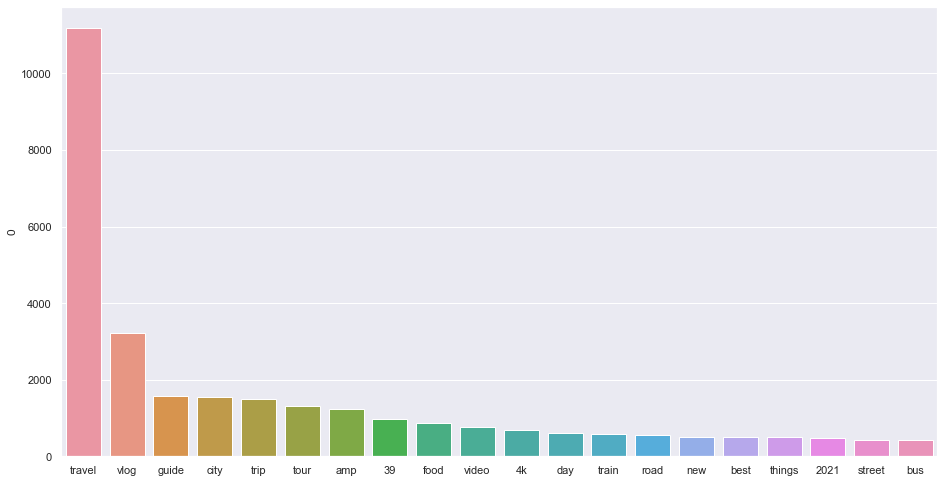

In [24]:
word_list = data_dtm.sum(axis = 0, skipna = True).sort_values(ascending = False)
word_list[0:20]
word = pd.DataFrame(word_list[0:20])
import seaborn as sns

sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(x = word.index, y = word[0])

It looks normal to me for the most part, but a couple things are more random like amp and 39, and those could be errors. So, after this MVP, I will definetely spend more time on data cleaning/preprocessing to clean up my data.

### Preparing the Data For Modeling

For my MVP, I will prepare the data to the format for modeling. In my MVP, I am trying a character prediction. So the prediction will be on what the next character in the sequence is. For my final project, I may try to use word embeddings and a bidirectional LSTM so that I can do word prediction

In [459]:
import re
alphabet_regular_expression = re.compile("[^a-zA-Z]")

def encode_decode(x):
    
    encoded_string = x.encode("ascii", "ignore")
    return re.sub(alphabet_regular_expression,"", encoded_string.decode().lower())


titles = files['video_title']
titles  = titles.apply(encode_decode)

title_list = list(titles)
title_sample = title_list
raw_text = ''.join(title_sample) + ' '




Count up all characters in the corpus and make dictionary to map word to integer.

In [460]:
chars = sorted(list(set(raw_text))) #List of every character
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)


Total Characters in the text; corpus length:  921941
Total Vocab:  27


Define size of dimensions of your variables

In [461]:
num_classes = n_vocab
batch_size = 100
learning_rate = 0.001

input_size = n_vocab
sequence_length = 100
hidden_size = 128
num_layers = 4


In order to standardize the length of each input vector, we need to create sequences that are the same length. For each sentence, we will create sequences of length 30, with shifts of 3 to cover different parts of that sequence. This way we capture a large percentage of each sentence, while still moving through the sentence list.

In [466]:
#For creating X-Y text input data from each title given:
seq_length = 100  #Length of each input sequence
step = 3   #Instead of moving 1 letter at a time, try skipping a few.
sentences = []    # X values (Sentences)
next_chars = []   # Y values. The character that follows the sentence defined as X
for title in title_sample:
    if seq_length > len(title):
        for i in range(0, len(title), step):  #step=1 means each sentence is offset just by a single letter
            sentences.append(f"{title[0: len(title) - i].rjust(seq_length)}")  #Sequence in
            try:
                next_chars.append(title[len(title) - i])  #Sequence out
            except:
                next_chars.append(' ')
        n_patterns = len(sentences)
    else:
        for i in range(0, len(title), step):  #step=1 means each sentence is offset just by a single letter
            start_point = len(title) - seq_length - i
            if start_point >= 0:
                sentences.append(f"{title[len(title) - seq_length - i: len(title) - i].rjust(seq_length)}")  #Sequence in
            else:
                sentences.append(
                    f"{title[0: len(title) - i].rjust(seq_length)}")  # Sequence in
            try:
                next_chars.append(title[len(title) - i])  #Sequence out
            except:
                next_chars.append(' ')


Turn the sequences into numpy arrays of fixed size, that can be processed by a neural network

In [467]:
import numpy as np

x = np.zeros((len(sentences), seq_length, n_vocab), dtype=bool)
y = np.zeros((len(sentences), n_vocab), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

x = x.astype('float32')
y = y.astype('float32')
print(x.shape)
print(y.shape)

(313834, 100, 27)
(313834, 27)


In [468]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

Use custom DataSet and DataLoader to structure data and load to model in increments

In [469]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        sample = {"x": x, "y": y}
        return sample

t_DS = TextDataset(X_train,y_train)
loader = DataLoader(t_DS ,batch_size = 256)


## Modeling

### Training

Create RNN class first, can try LSTM and GRU architecture later on.

In [470]:
import torch
from torchinfo import summary
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        #out = self.softmax(out)
        # out: (n, 10)
        return out


In [499]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        #out, _ = self.lstm(x, h0)  
        # or:
        out, _ = self.lstm(x, (h0,c0))
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        #out = self.softmax(out)
        # out: (n, 10)
        return out

In [309]:
# Fully connected neural network with one hidden layer
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        #self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.gru(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        #out = self.softmax(out)
        # out: (n, 10)
        return out


Create model object from RNN class, then specify training parameters

In [471]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
EPOCHS = 5
BATCH_SIZE = 256


In [559]:
model_lstm = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
EPOCHS = 150
BATCH_SIZE = 512


In [163]:
model_gru = GRU(input_size, hidden_size, num_layers, num_classes).to(device)
EPOCHS = 30
BATCH_SIZE = 256


Specific Loss function and Optimizer

In [560]:
from torch.optim import Adam, RMSprop
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)  


Create Training Loop for specified amount of epochs

In [561]:
loss_list = []
for epoch in range(EPOCHS):
    loss = 0
    correct = 0
    for i, data in tqdm(enumerate(loader)):
        x_train_m, y_train_m = data['x'], data['y']
        x_train_m = x_train_m.to(device)
        y_train_m = y_train_m.to(device)

        outputs = model_lstm(x_train_m)
        loss = criterion(outputs, y_train_m)
        loss_list.append(loss)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print('Epoch {} Loss : {}'.format((epoch+1),loss))


981it [00:25, 39.22it/s]


Epoch 1 Loss : 2.516052722930908


981it [00:24, 39.29it/s]


Epoch 2 Loss : 2.3012382984161377


981it [00:24, 39.28it/s]


Epoch 3 Loss : 2.1549429893493652


981it [00:25, 38.99it/s]


Epoch 4 Loss : 2.04616117477417


981it [00:25, 38.72it/s]


Epoch 5 Loss : 1.9388805627822876


981it [00:25, 39.02it/s]


Epoch 6 Loss : 1.851061224937439


981it [00:25, 39.00it/s]


Epoch 7 Loss : 1.7520618438720703


981it [00:25, 39.08it/s]


Epoch 8 Loss : 1.6670738458633423


981it [00:25, 39.03it/s]


Epoch 9 Loss : 1.597827434539795


981it [00:25, 38.95it/s]


Epoch 10 Loss : 1.5475162267684937


981it [00:25, 39.03it/s]


Epoch 11 Loss : 1.5025997161865234


981it [00:25, 39.00it/s]


Epoch 12 Loss : 1.4393850564956665


981it [00:25, 38.97it/s]


Epoch 13 Loss : 1.3705049753189087


981it [00:25, 39.01it/s]


Epoch 14 Loss : 1.2939780950546265


981it [00:25, 39.03it/s]


Epoch 15 Loss : 1.2149131298065186


981it [00:25, 38.93it/s]


Epoch 16 Loss : 1.1764531135559082


981it [00:25, 38.78it/s]


Epoch 17 Loss : 1.1361521482467651


981it [00:24, 39.31it/s]


Epoch 18 Loss : 1.06533944606781


981it [00:24, 39.32it/s]


Epoch 19 Loss : 1.033179759979248


981it [00:24, 39.30it/s]


Epoch 20 Loss : 0.9815126657485962


981it [00:25, 38.34it/s]


Epoch 21 Loss : 0.9672287106513977


981it [00:25, 38.86it/s]


Epoch 22 Loss : 0.93413245677948


981it [00:25, 38.84it/s]


Epoch 23 Loss : 0.9076480865478516


981it [00:25, 38.71it/s]


Epoch 24 Loss : 0.8745600581169128


981it [00:25, 38.74it/s]


Epoch 25 Loss : 0.8531128764152527


981it [00:25, 39.06it/s]


Epoch 26 Loss : 0.8199025392532349


981it [00:25, 39.05it/s]


Epoch 27 Loss : 0.7909573912620544


981it [00:25, 39.15it/s]


Epoch 28 Loss : 0.7820140719413757


981it [00:24, 39.26it/s]


Epoch 29 Loss : 0.7413816452026367


981it [00:25, 39.09it/s]


Epoch 30 Loss : 0.756412148475647


981it [00:25, 39.17it/s]


Epoch 31 Loss : 0.7359917759895325


981it [00:25, 38.79it/s]


Epoch 32 Loss : 0.7565248012542725


981it [00:25, 39.22it/s]


Epoch 33 Loss : 0.7471620440483093


981it [00:24, 39.30it/s]


Epoch 34 Loss : 0.7574394345283508


981it [00:25, 38.38it/s]


Epoch 35 Loss : 0.751645028591156


981it [00:25, 39.15it/s]


Epoch 36 Loss : 0.7078405618667603


981it [00:24, 39.35it/s]


Epoch 37 Loss : 0.6992992162704468


981it [00:24, 39.62it/s]


Epoch 38 Loss : 0.6687524914741516


981it [00:24, 39.50it/s]


Epoch 39 Loss : 0.6641650795936584


981it [00:24, 39.60it/s]


Epoch 40 Loss : 0.642357587814331


981it [00:24, 39.46it/s]


Epoch 41 Loss : 0.7007085680961609


981it [00:24, 39.58it/s]


Epoch 42 Loss : 0.6272953748703003


981it [00:24, 39.50it/s]


Epoch 43 Loss : 0.6434057950973511


981it [00:24, 39.55it/s]


Epoch 44 Loss : 0.6002674698829651


981it [00:24, 39.49it/s]


Epoch 45 Loss : 0.60325026512146


981it [00:24, 39.50it/s]


Epoch 46 Loss : 0.5472723245620728


981it [00:24, 39.56it/s]


Epoch 47 Loss : 0.5399752855300903


981it [00:24, 39.57it/s]


Epoch 48 Loss : 0.5318522453308105


981it [00:24, 39.60it/s]


Epoch 49 Loss : 0.5172843933105469


981it [00:24, 39.56it/s]


Epoch 50 Loss : 0.5001539587974548


981it [00:24, 39.52it/s]


Epoch 51 Loss : 0.5053878426551819


981it [00:24, 39.57it/s]


Epoch 52 Loss : 0.5455977320671082


981it [00:24, 39.59it/s]


Epoch 53 Loss : 0.544485330581665


981it [00:24, 39.59it/s]


Epoch 54 Loss : 0.5100724697113037


981it [00:24, 39.48it/s]


Epoch 55 Loss : 0.4760521948337555


981it [00:24, 39.58it/s]


Epoch 56 Loss : 0.5159765481948853


981it [00:24, 39.40it/s]


Epoch 57 Loss : 0.4868182837963104


981it [00:24, 39.48it/s]


Epoch 58 Loss : 0.5156821608543396


981it [00:24, 39.57it/s]


Epoch 59 Loss : 0.4122600853443146


981it [00:24, 39.59it/s]


Epoch 60 Loss : 0.48033028841018677


981it [00:24, 39.44it/s]


Epoch 61 Loss : 0.4575497806072235


981it [00:24, 39.59it/s]


Epoch 62 Loss : 0.44467246532440186


981it [00:24, 39.57it/s]


Epoch 63 Loss : 0.4817295968532562


981it [00:24, 39.58it/s]


Epoch 64 Loss : 0.4640929102897644


981it [00:24, 39.57it/s]


Epoch 65 Loss : 0.5214649438858032


981it [00:24, 39.59it/s]


Epoch 66 Loss : 0.4498595595359802


981it [00:24, 39.55it/s]


Epoch 67 Loss : 0.42863360047340393


981it [00:24, 39.42it/s]


Epoch 68 Loss : 0.4197321832180023


981it [00:24, 39.53it/s]


Epoch 69 Loss : 0.41431233286857605


981it [00:24, 39.56it/s]


Epoch 70 Loss : 0.4475448727607727


981it [00:24, 39.60it/s]


Epoch 71 Loss : 0.37283194065093994


981it [00:25, 38.73it/s]


Epoch 72 Loss : 0.41104787588119507


981it [00:25, 37.92it/s]


Epoch 73 Loss : 0.3627680838108063


981it [00:26, 37.49it/s]


Epoch 74 Loss : 0.3646409213542938


981it [00:25, 38.40it/s]


Epoch 75 Loss : 0.38921794295310974


981it [00:25, 39.08it/s]


Epoch 76 Loss : 0.35861942172050476


981it [00:25, 39.09it/s]


Epoch 77 Loss : 0.3755281865596771


981it [00:25, 39.11it/s]


Epoch 78 Loss : 0.3527972102165222


981it [00:25, 39.18it/s]


Epoch 79 Loss : 0.3907797932624817


981it [00:25, 39.08it/s]


Epoch 80 Loss : 0.3678535521030426


981it [00:25, 39.17it/s]


Epoch 81 Loss : 0.30625274777412415


981it [00:25, 39.12it/s]


Epoch 82 Loss : 0.3871231973171234


981it [00:25, 39.03it/s]


Epoch 83 Loss : 0.38736337423324585


981it [00:25, 39.12it/s]


Epoch 84 Loss : 0.33576521277427673


981it [00:25, 39.08it/s]


Epoch 85 Loss : 0.37777936458587646


981it [00:25, 39.15it/s]


Epoch 86 Loss : 0.34289607405662537


981it [00:25, 39.18it/s]


Epoch 87 Loss : 0.3423638343811035


981it [00:25, 39.17it/s]


Epoch 88 Loss : 0.34023505449295044


981it [00:25, 39.00it/s]


Epoch 89 Loss : 0.35368576645851135


981it [00:25, 39.19it/s]


Epoch 90 Loss : 0.609477162361145


981it [00:25, 39.13it/s]


Epoch 91 Loss : 0.4278314411640167


981it [00:25, 39.13it/s]


Epoch 92 Loss : 0.3069855868816376


981it [00:25, 39.01it/s]


Epoch 93 Loss : 0.30794668197631836


981it [00:25, 39.10it/s]


Epoch 94 Loss : 0.34849050641059875


981it [00:25, 39.11it/s]


Epoch 95 Loss : 0.33264631032943726


981it [00:25, 39.22it/s]


Epoch 96 Loss : 0.32492154836654663


981it [00:25, 39.02it/s]


Epoch 97 Loss : 0.3654658794403076


981it [00:25, 39.20it/s]


Epoch 98 Loss : 0.3312154710292816


981it [00:25, 39.15it/s]


Epoch 99 Loss : 0.3042057454586029


981it [00:25, 39.12it/s]


Epoch 100 Loss : 0.31878527998924255


981it [00:25, 39.20it/s]


Epoch 101 Loss : 0.2969978451728821


981it [00:25, 39.21it/s]


Epoch 102 Loss : 0.296688973903656


981it [00:24, 39.25it/s]


Epoch 103 Loss : 0.33944958448410034


981it [00:25, 39.12it/s]


Epoch 104 Loss : 0.32738497853279114


981it [00:26, 37.55it/s]


Epoch 105 Loss : 0.3766142427921295


981it [00:25, 38.21it/s]


Epoch 106 Loss : 0.35272926092147827


981it [00:25, 38.33it/s]


Epoch 107 Loss : 0.3036966323852539


981it [00:25, 39.12it/s]


Epoch 108 Loss : 0.34852176904678345


981it [00:25, 38.88it/s]


Epoch 109 Loss : 0.2568229138851166


981it [00:24, 39.58it/s]


Epoch 110 Loss : 0.3222510516643524


981it [00:25, 39.02it/s]


Epoch 111 Loss : 0.3726006746292114


981it [00:25, 38.42it/s]


Epoch 112 Loss : 0.29310837388038635


981it [00:26, 37.31it/s]


Epoch 113 Loss : 0.26033729314804077


981it [00:25, 38.19it/s]


Epoch 114 Loss : 0.26559028029441833


981it [00:25, 38.90it/s]


Epoch 115 Loss : 0.2984071373939514


981it [00:25, 38.01it/s]


Epoch 116 Loss : 0.3352397680282593


981it [00:26, 37.68it/s]


Epoch 117 Loss : 0.2909165620803833


981it [00:25, 38.27it/s]


Epoch 118 Loss : 0.30562371015548706


981it [00:26, 37.70it/s]


Epoch 119 Loss : 0.28318601846694946


981it [00:25, 38.83it/s]


Epoch 120 Loss : 0.3147442638874054


981it [00:25, 38.03it/s]


Epoch 121 Loss : 0.301831990480423


981it [00:25, 38.18it/s]


Epoch 122 Loss : 0.351779967546463


981it [00:25, 37.92it/s]


Epoch 123 Loss : 0.2582119107246399


981it [00:26, 37.35it/s]


Epoch 124 Loss : 0.29497241973876953


981it [00:25, 38.23it/s]


Epoch 125 Loss : 0.3179934620857239


981it [00:25, 39.17it/s]


Epoch 126 Loss : 0.31544992327690125


981it [00:24, 39.63it/s]


Epoch 127 Loss : 0.3034929037094116


981it [00:24, 39.60it/s]


Epoch 128 Loss : 0.2997661828994751


981it [00:24, 39.52it/s]


Epoch 129 Loss : 0.32600197196006775


981it [00:24, 39.36it/s]


Epoch 130 Loss : 0.3118661642074585


981it [00:25, 39.03it/s]


Epoch 131 Loss : 0.23122897744178772


981it [00:24, 39.58it/s]


Epoch 132 Loss : 0.2392439842224121


981it [00:24, 39.27it/s]


Epoch 133 Loss : 0.24232779443264008


981it [00:25, 38.39it/s]


Epoch 134 Loss : 0.28437095880508423


981it [00:25, 38.61it/s]


Epoch 135 Loss : 0.2960241734981537


981it [00:25, 38.31it/s]


Epoch 136 Loss : 0.3349132537841797


981it [00:25, 38.58it/s]


Epoch 137 Loss : 0.2814907133579254


981it [00:25, 39.13it/s]


Epoch 138 Loss : 0.23638300597667694


981it [00:25, 39.09it/s]


Epoch 139 Loss : 0.3246980905532837


981it [00:24, 39.56it/s]


Epoch 140 Loss : 0.3141261041164398


981it [00:25, 38.92it/s]


Epoch 141 Loss : 0.3361186683177948


981it [00:25, 39.22it/s]


Epoch 142 Loss : 0.26920396089553833


981it [00:25, 38.98it/s]


Epoch 143 Loss : 0.3195820450782776


981it [00:25, 39.20it/s]


Epoch 144 Loss : 0.3451942801475525


981it [00:24, 39.27it/s]


Epoch 145 Loss : 0.30971020460128784


981it [00:24, 39.36it/s]


Epoch 146 Loss : 0.2801271677017212


981it [00:26, 37.61it/s]


Epoch 147 Loss : 0.2871032953262329


981it [00:25, 39.16it/s]


Epoch 148 Loss : 0.3313862979412079


981it [00:26, 37.21it/s]


Epoch 149 Loss : 0.2782670259475708


981it [00:25, 38.32it/s]

Epoch 150 Loss : 0.23591884970664978


### Testing

Still in progress, need further training, and to fix testing loop

In [98]:
x_test_set = x[0:5000,:,:]
y_test_set = y[0:5000,:]

In [ ]:
test_DS = TextDataset(X_test,y_test)
test_loader = DataLoader(test_DS ,batch_size = 512)


In [507]:
def get_predictions(outputs):
    filtered_output = np.zeros_like(outputs)
    filtered_output[np.arange(len(outputs)), outputs.argmax(1)] = 1
    final_int = filtered_output.argmax(axis = 1)
    predictions = []
    for letter in final_int:
        predictions.append(int_to_char[letter])
    
    return predictions


get_predictions(outputs.cpu().detach().numpy())

['g',
 ' ',
 'g',
 'g',
 'e',
 'v',
 'l',
 ' ',
 ' ',
 'i',
 't',
 't',
 'a',
 'a',
 'a',
 ' ',
 'd',
 'r',
 'a',
 'n',
 'r',
 'f',
 'd',
 's',
 't',
 'a',
 'a',
 'n',
 'r',
 'l',
 'd',
 't',
 ' ',
 'a',
 'a',
 't',
 'a',
 'r',
 'n',
 'r',
 'i',
 'a',
 'n',
 'c',
 'g',
 'a',
 's',
 'e',
 ' ',
 'a',
 't',
 'v',
 'a',
 'o',
 'l',
 'o',
 'i',
 'e',
 'd',
 'e',
 'i',
 'a',
 'a',
 't',
 'l',
 'o',
 ' ',
 'a',
 'r',
 'a',
 'd',
 ' ',
 's',
 'l',
 'o',
 's',
 'e',
 'e',
 'n',
 'h',
 't',
 'o',
 't',
 'a',
 ' ',
 'l',
 'g',
 'r',
 'c',
 'a',
 'o',
 's',
 't',
 ' ',
 'e',
 't',
 'n',
 'y',
 'i',
 'i',
 'a',
 's',
 'n',
 'e',
 ' ',
 'r',
 'a',
 'e',
 'n',
 'l',
 's',
 'l',
 'd',
 'a',
 'f',
 ' ',
 'i',
 'r',
 's',
 'a',
 'a',
 'n',
 ' ',
 'e',
 's',
 'a',
 'r',
 't',
 'o',
 'i',
 'e',
 ' ',
 'g',
 'd',
 'k',
 'a',
 't',
 'n',
 'x',
 'n',
 'r',
 'a',
 'n',
 's',
 'a',
 'v',
 'e',
 'a',
 'i',
 'n',
 'g',
 'e',
 ' ',
 'i',
 'f',
 'o',
 'e',
 ' ',
 'y',
 ' ',
 'm',
 'a',
 'v',
 'o',
 'h',
 'r',
 'e'

In [ ]:
def get_predictions_second(outputs):
    filtered_output = np.zeros_like(outputs)
    filtered_output[np.arange(len(outputs)), outputs.argmax(1)] = 1
    final_int = np.argsort(filtered_output, axis=1)[:,-1]
    return final_int

get_predictions_second(outputs.cpu().detach().numpy())

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i, data in tqdm(enumerate(test_loader)):
        x_test_m, y_test_m = data['x'], data['y']
        x_test_m = x_test_m.to(device)
        y_test_m = y_test_m.to(device)
        outputs = model_lstm(x_test_m).cpu().numpy()
        filtered_output = np.zeros_like(outputs)
        filtered_output[np.arange(len(outputs)), outputs.argmax(1)] = 1
        
        #_, predicted = torch.max(outputs.data, 1)
        n_samples += y_test_m.size(0)
        n_correct += np.sum(np.array(get_predictions(filtered_output)) == np.array(get_predictions(y_test_m.cpu().numpy())))


        
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')
  


In [141]:
np.sum(np.array(get_predictions(filtered_output)) == np.array(get_predictions(y_test_m.cpu().numpy())))



58

In [383]:
import unittest 
class TestFunctions(unittest.TestCase): 
    def test_predictions_matrix(self): 
        assert len(get_predictions(outputs)) == outputs.shape[0]

    def test_second(self):
        assert type(get_predictions_second(outputs)) is int
unittest.main(argv=[''], verbosity=2, exit=False)


test_predictions_matrix (__main__.TestFunctions) ... ok
test_second (__main__.TestFunctions) ... FAIL

FAIL: test_second (__main__.TestFunctions)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\kenhu\AppData\Local\Temp/ipykernel_11888/2031806237.py", line 7, in test_second
    assert type(get_predictions_second(outputs)) is int
AssertionError

----------------------------------------------------------------------
Ran 2 tests in 0.003s

FAILED (failures=1)


In [557]:
sentence = 'roadtrip'
sentence = sentence.rjust(seq_length)
generated = sentence

In [558]:
import sys


for i in range(60):   # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.
    x_pred = x_pred.astype('float32')
    x_pred = torch.from_numpy(x_pred).to(device)
    preds = model_lstm(x_pred).cpu().detach().numpy()
    #print(preds)
    next_char = get_predictions(preds)[0]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print(generated)



vodagemukahipalingtheiltingshorts ocitilesandomentssortsinro                                                                                            roadtripvodagemukahipalingtheiltingshorts ocitilesandomentssortsinro


In [125]:
preds.cpu().detach().numpy()

array([[ 3.473044  , -1.6067774 , -4.8023868 , -6.0202785 , -7.410056  ,
        -1.177187  , -4.3759823 , -2.3694432 , -5.0864434 , -5.686878  ,
        -0.73352265, -1.9418195 , -1.0261691 , -1.908966  , -3.4814541 ,
        -2.6615489 , -2.4907494 , -1.8747177 , -3.0576973 , -2.6913378 ,
        -2.9519777 , -2.448581  , -2.315035  , -2.8207023 , -1.876294  ,
        -9.371428  , -7.016985  , -3.2558498 , -5.334759  , -5.101123  ,
        -4.7987666 , -5.320304  , -8.154394  , -5.178426  , -6.9275665 ,
         0.2309207 ,  1.0595065 ,  2.1929283 ,  0.98417896, -1.1793524 ,
         2.2904058 ,  1.9806143 ,  0.3018907 , -0.8691815 , -2.2329247 ,
         0.3834435 , -1.0320481 ,  2.0991518 ,  3.6967103 ,  1.8505684 ,
         2.6434188 , -3.0986857 ,  3.3486764 ,  1.7970933 ,  0.36995444,
         2.5554717 ,  2.3016772 ,  3.2990541 ,  0.32242757, -0.4407666 ,
        -1.6383371 , -8.762027  , -2.2224083 , -7.8601203 , -6.4827514 ]],
      dtype=float32)